# ADVANCED ARCHITECTURE ON CIFAR10

Files already downloaded and verified
Files already downloaded and verified

Epoch 1/40.
[1,   100] loss: 2.176
[1,   200] loss: 1.863
[1,   300] loss: 1.743
Training accuracy: 0.4105199873447418. Testing accuracy: 0.444599986076355. Duration: 97.589s.

Epoch 2/40.
[2,   100] loss: 1.593
[2,   200] loss: 1.532
[2,   300] loss: 1.477
Training accuracy: 0.49601998925209045. Testing accuracy: 0.5299000144004822. Duration: 98.858s.

Epoch 3/40.
[3,   100] loss: 1.356
[3,   200] loss: 1.323
[3,   300] loss: 1.291
Training accuracy: 0.5413199663162231. Testing accuracy: 0.5720999836921692. Duration: 97.292s.

Epoch 4/40.
[4,   100] loss: 1.214
[4,   200] loss: 1.171
[4,   300] loss: 1.144
Training accuracy: 0.6036999821662903. Testing accuracy: 0.6157000064849854. Duration: 97.536s.

Epoch 5/40.
[5,   100] loss: 1.087
[5,   200] loss: 1.081
[5,   300] loss: 1.049
Training accuracy: 0.6425399780273438. Testing accuracy: 0.667199969291687. Duration: 97.785s.

Epoch 6/40.
[6,   100] loss: 1.000

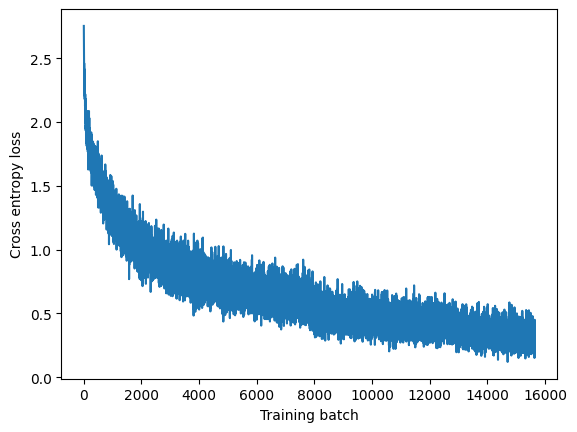

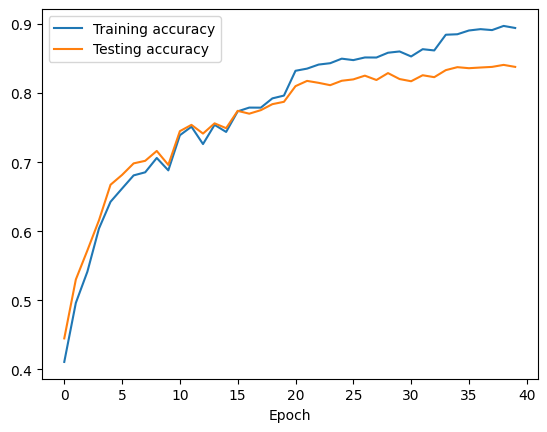

Best testing accuracy: 0.0


In [6]:
#NAME : Yashas Ravichandra
#STUDENT ID : 230046616

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the dataset and data loaders with data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Defining the ResNet block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

# Defining the IntermediateBlock
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, kernel_size=3, activation=nn.ReLU()):
        super(IntermediateBlock, self).__init__()
        self.conv_layers = nn.ModuleList([])
        for _ in range(num_layers):
            self.conv_layers.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2),
                nn.BatchNorm2d(out_channels),
                activation
            ))
        self.fc = nn.Linear(in_channels, num_layers)

    def forward(self, x):
        m = x.mean([2, 3])  # Computing the mean separately for each color channel
        a = torch.softmax(self.fc(m), dim=1)  # Calculate a by sending it to a fully connected layer
        x_prime = sum(a[:, i].view(-1, 1, 1, 1) * conv(x) for i, conv in enumerate(self.conv_layers))
        return x_prime

# Defining the OutputBlock
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes, num_fc_layers=1, activation=nn.ReLU()):
        super(OutputBlock, self).__init__()
        self.fc_layers = nn.ModuleList([nn.Linear(in_channels, in_channels) for _ in range(num_fc_layers - 1)])
        self.fc_layers.append(nn.Linear(in_channels, num_classes))
        self.activation = activation

    def forward(self, x):
        m = x.mean([2, 3])
        for fc in self.fc_layers[:-1]:
            m = self.activation(fc(m))
        o = self.fc_layers[-1](m)
        return o

# Defining the ResNet model
class ResNet(nn.Module):
    def __init__(self, input_channels, output_shape, num_blocks, num_conv_layers, block=ResNetBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_conv_layers, stride=1)
        self.layer2 = self._make_layer(block, 128, num_conv_layers, stride=2)
        self.layer3 = self._make_layer(block, 256, num_conv_layers, stride=2)
        self.layer4 = self._make_layer(block, 512, num_conv_layers, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.output_block = OutputBlock(512, output_shape)

    def _make_layer(self, block, out_channels, num_conv_layers, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(num_conv_layers - 1):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = self.output_block(out)
        return out

# Defining the loss function, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(input_channels=3, output_shape=10, num_blocks=4, num_conv_layers=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0125, momentum=0.9, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

def correct(logits, y):
    y_hat = logits.argmax(axis=1)
    return (y_hat == y).float().sum()

def evaluate_metric(model, data_iter, metric):
    """Compute the average metric of the model on a dataset."""
    c = 0.
    n = 0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return float(c / n)

# Implement the training loop with early stopping and gradient clipping
def train(model, trainloader, criterion, optimizer, scheduler, num_epochs=100, early_stop=10, clip_value=1.0):
    losses = []
    train_accs = []
    test_accs = []
    best_test_acc = 0.0
    patience = 0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}.')
        start_time = time.perf_counter()
        model.train()

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()


            nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()

            running_loss += loss.item()
            losses.append(float(loss))

            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

        with torch.no_grad():
            model.eval()
            train_acc = evaluate_metric(model, trainloader, correct)
            test_acc = evaluate_metric(model, testloader, correct)
            train_accs.append(train_acc)
            test_accs.append(test_acc)

            scheduler.step(loss)

        end_time = time.perf_counter()
        print(f'Training accuracy: {train_acc}. Testing accuracy: {test_acc}. Duration: {end_time - start_time:.3f}s.')

    # Plot the loss for each training batch
    plt.figure()
    plt.plot(losses)
    plt.xlabel('Training batch')
    plt.ylabel('Cross entropy loss')
    plt.show()

    # Plot the training and testing accuracy for each epoch
    plt.figure()
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(test_accs, label='Testing accuracy')
    plt.legend(loc='best')
    plt.xlabel('Epoch')
    plt.show()

    return best_test_acc

# Train the model
num_epochs = 40
early_stop = 10
clip_value = 1.0
best_test_acc = train(model, trainloader, criterion, optimizer, scheduler, num_epochs, early_stop, clip_value)
print(f'Best testing accuracy: {best_test_acc}')